In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import pickle
import sbi.utils as utils
import torch
from sbi.inference import MCMCPosterior
from scipy.special import logsumexp

from collective_posterior import CollectivePosterior

import matplotlib as mpl
plt.rcParams['figure.dpi'] = 600

# Get Collective Posterior
## $P(\theta|X_{1},...X_{n}) = $${{P(\theta)}^{1-n}\Pi_{i}[P(\theta|X_{i})]} \over {\int{{P(\theta)}^{1-n}}\Pi_{i}[P(\theta|X_{i})]d\theta}$

In [2]:
# Prior doesn't have to be identical to network's prior (here it is)
prior_min = np.log10(np.array([1e-2,1e-7,1e-8]))
prior_max = np.log10(np.array([1,1e-2,1e-2]))
prior = utils.BoxUniform(low=torch.tensor(prior_min), 
                         high=torch.tensor(prior_max))
posterior_chuong = pickle.load(open(f'posteriors/posterior_chuong.pkl', 'rb'))
# posterior_lauer = pickle.load(open(f'posteriors/posterior_lauer.pkl', 'rb'))
n_eval = 300 # N used to calculate normalizng constant
epsilon = -150 # choice is detailed later
log_Cs = pd.read_csv('posteriors/log_Cs.csv', index_col=0) # pre-saved normalizing constant
sample_df = pd.read_csv('maps/collective_posterior_samples.csv', index_col=0) # pre-saved samples

collective_posteriors = {}

lines = ['wt', 'ltr', 'ars', 'all']
for line in lines:
    amortized_posterior = posterior_lauer if line=='lauer' else posterior_chuong
    Xs = pd.read_csv(f'empirical_data/{line}.csv', index_col=0) # observations
    log_C = float(log_Cs.loc[line,str(epsilon)]) # normalizing constant
    op = CollectivePosterior(prior, amortized_posterior, Xs, n_eval, log_C, epsilon)
    samples = sample_df[sample_df['line']==line].iloc[:,1:] # only parameter values
    op.samples = torch.tensor(np.array(samples,dtype='float64')).reshape(len(samples),3)
    collective_posteriors[line] = op # to use throughout the notebook
    
rep_colors = {'wt':"black", 'ltr':"#6699cc", 'ars': "#e26d5c", 'all':"#DEBD52", "lauer": "grey"}
label_dict = {'wt': 'Wild type architecture', 'ltr': 'LTRs removed', 'ars': 'ARS removed', 'all': 'LTR and ARS removed', 'lauer': 'Lauer'}

# Collective MAPs (Maximum A-Posteriori)

In [3]:
for line in lines:
    print(f'{line} MAP: {list(collective_posteriors[line].get_map().round(2))}')

wt MAP: [-0.74, -4.34, -3.77]
ltr MAP: [-0.74, -4.84, -4.32]
ars MAP: [-0.84, -5.62, -5.39]
all MAP: [-0.9, -5.05, -5.22]


# Marginal Collective Posteriors

In [14]:
import matplotlib as mpl

# fonts
label_size = 7
mpl.rcParams['xtick.labelsize'] = label_size 
mpl.rcParams['ytick.labelsize'] = label_size 
mpl.rcParams['font.size'] = 16

# add specifics to plotting function
def plotline(line):
        op = collective_posteriors[line]
        g = op.plot_pairwise(color=rep_colors[line])  
        g.fig.suptitle(label_dict[line])
        plt.show()

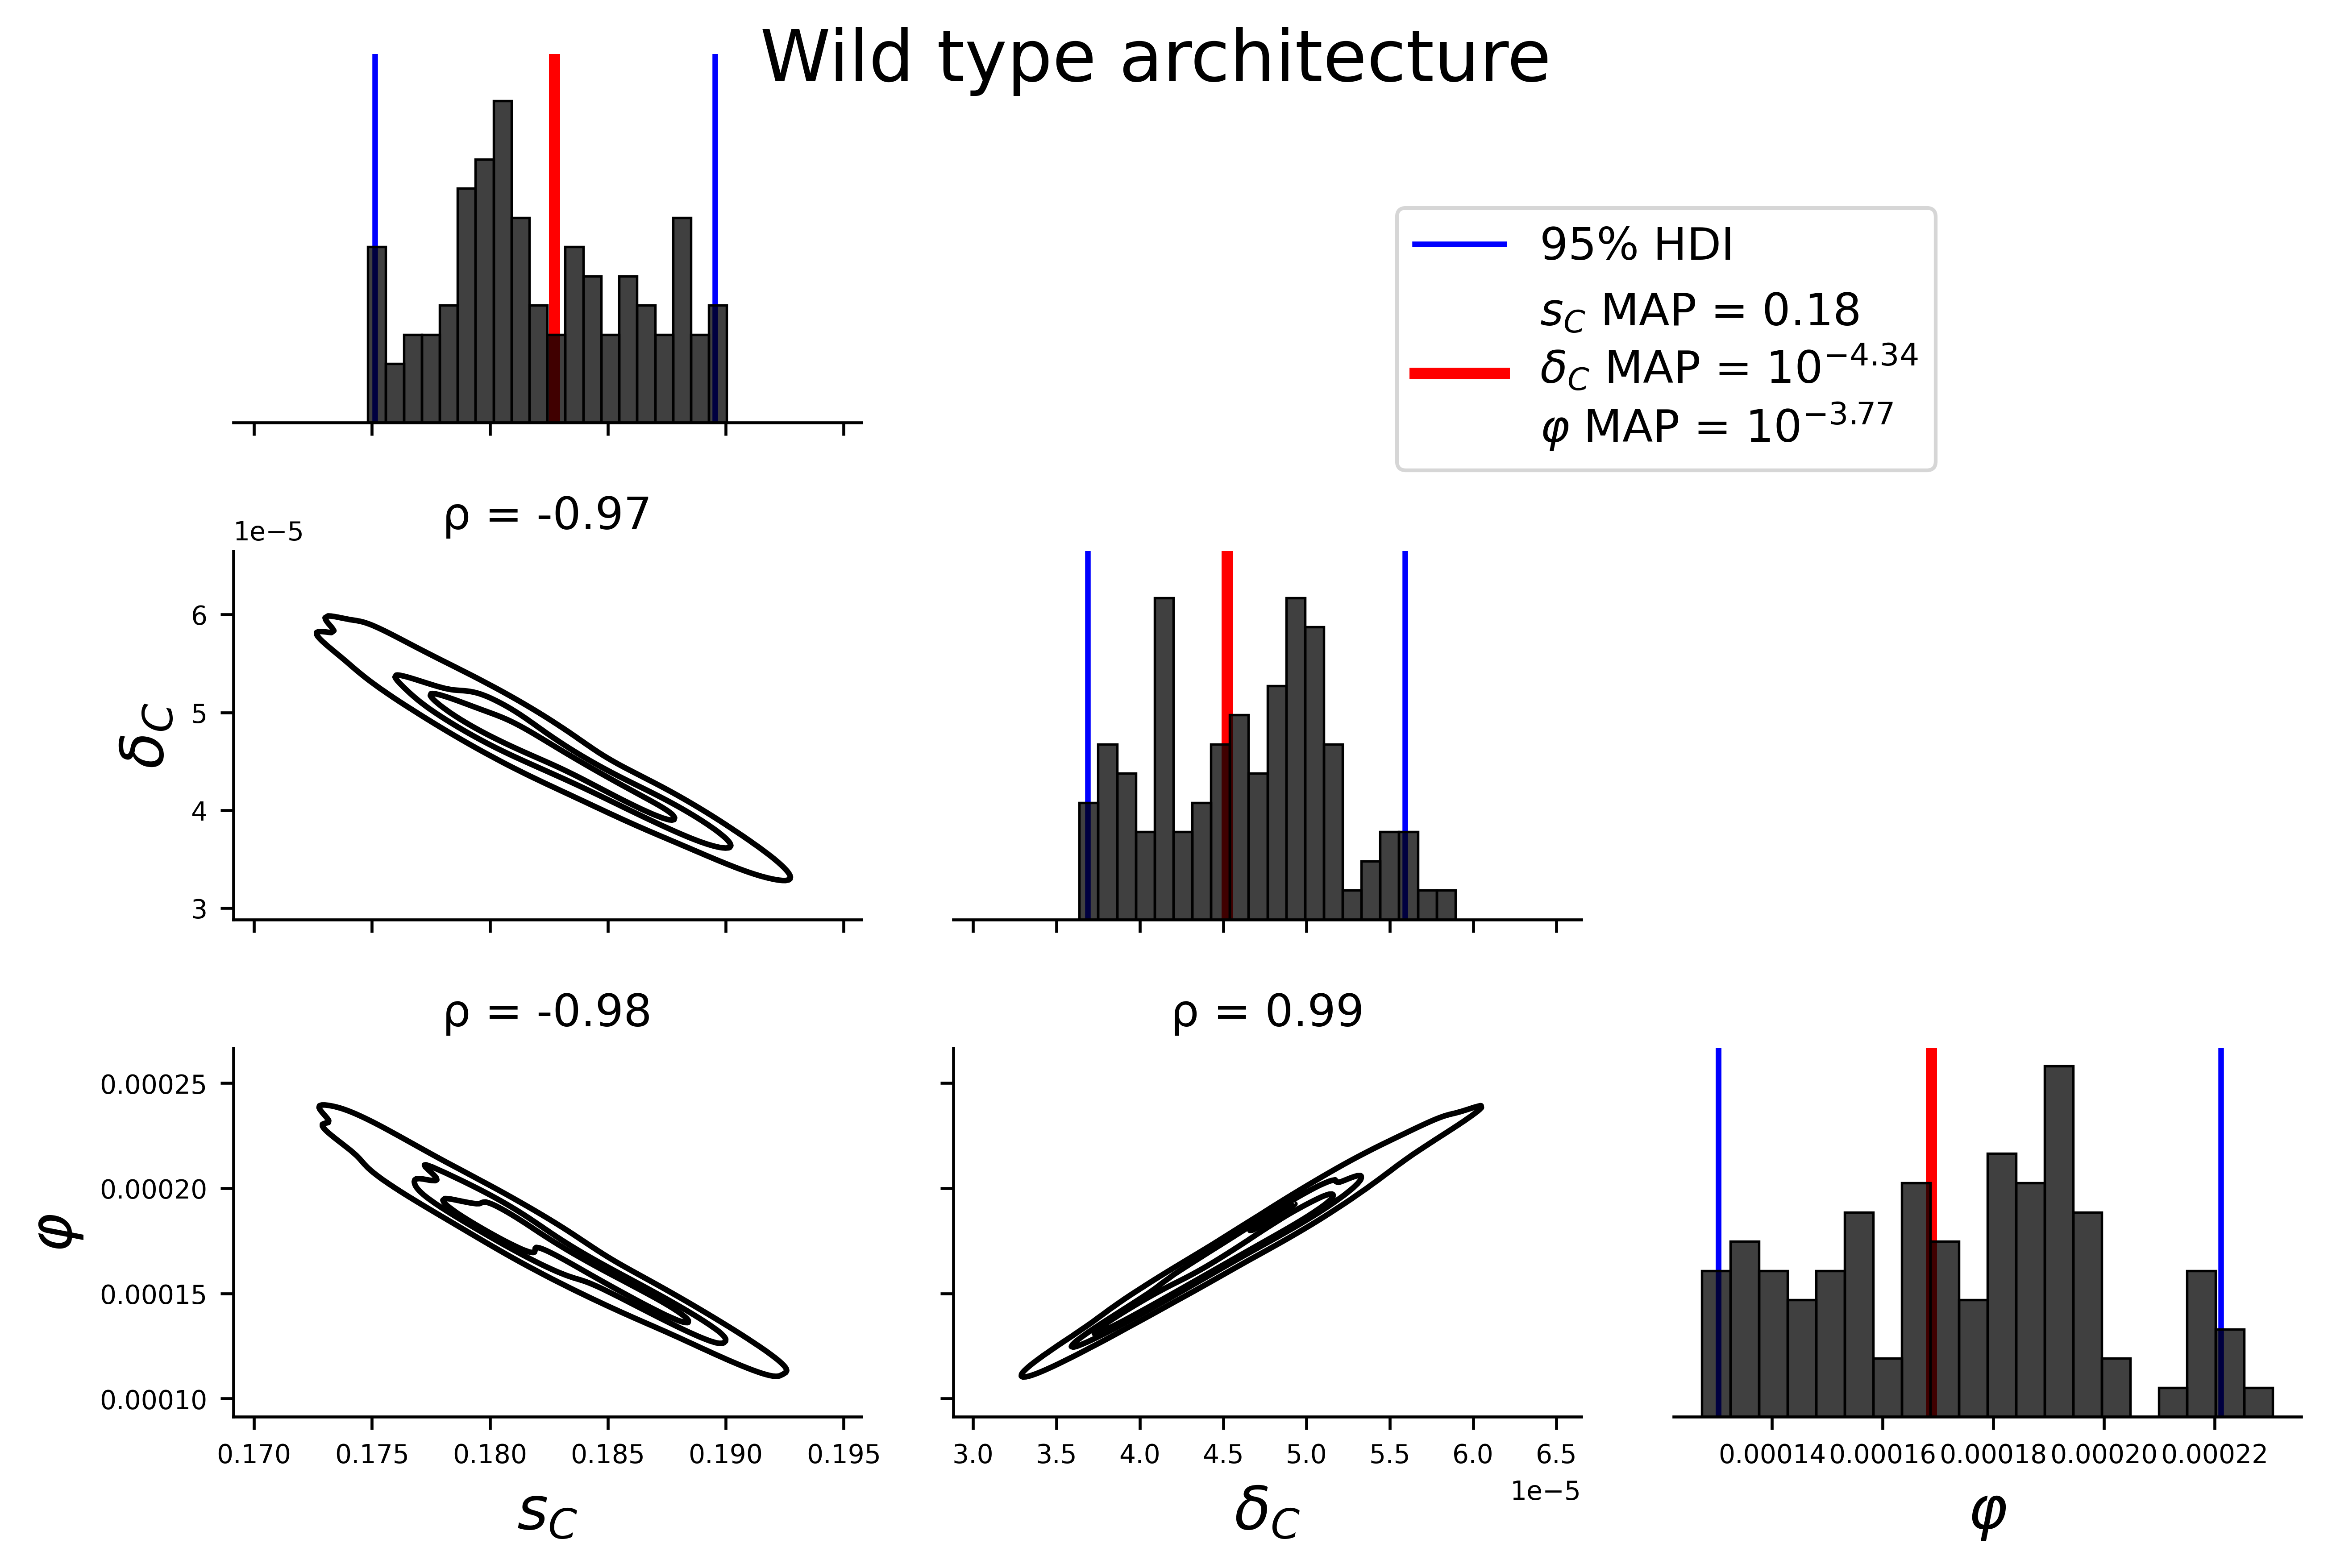

In [19]:
plotline('wt')

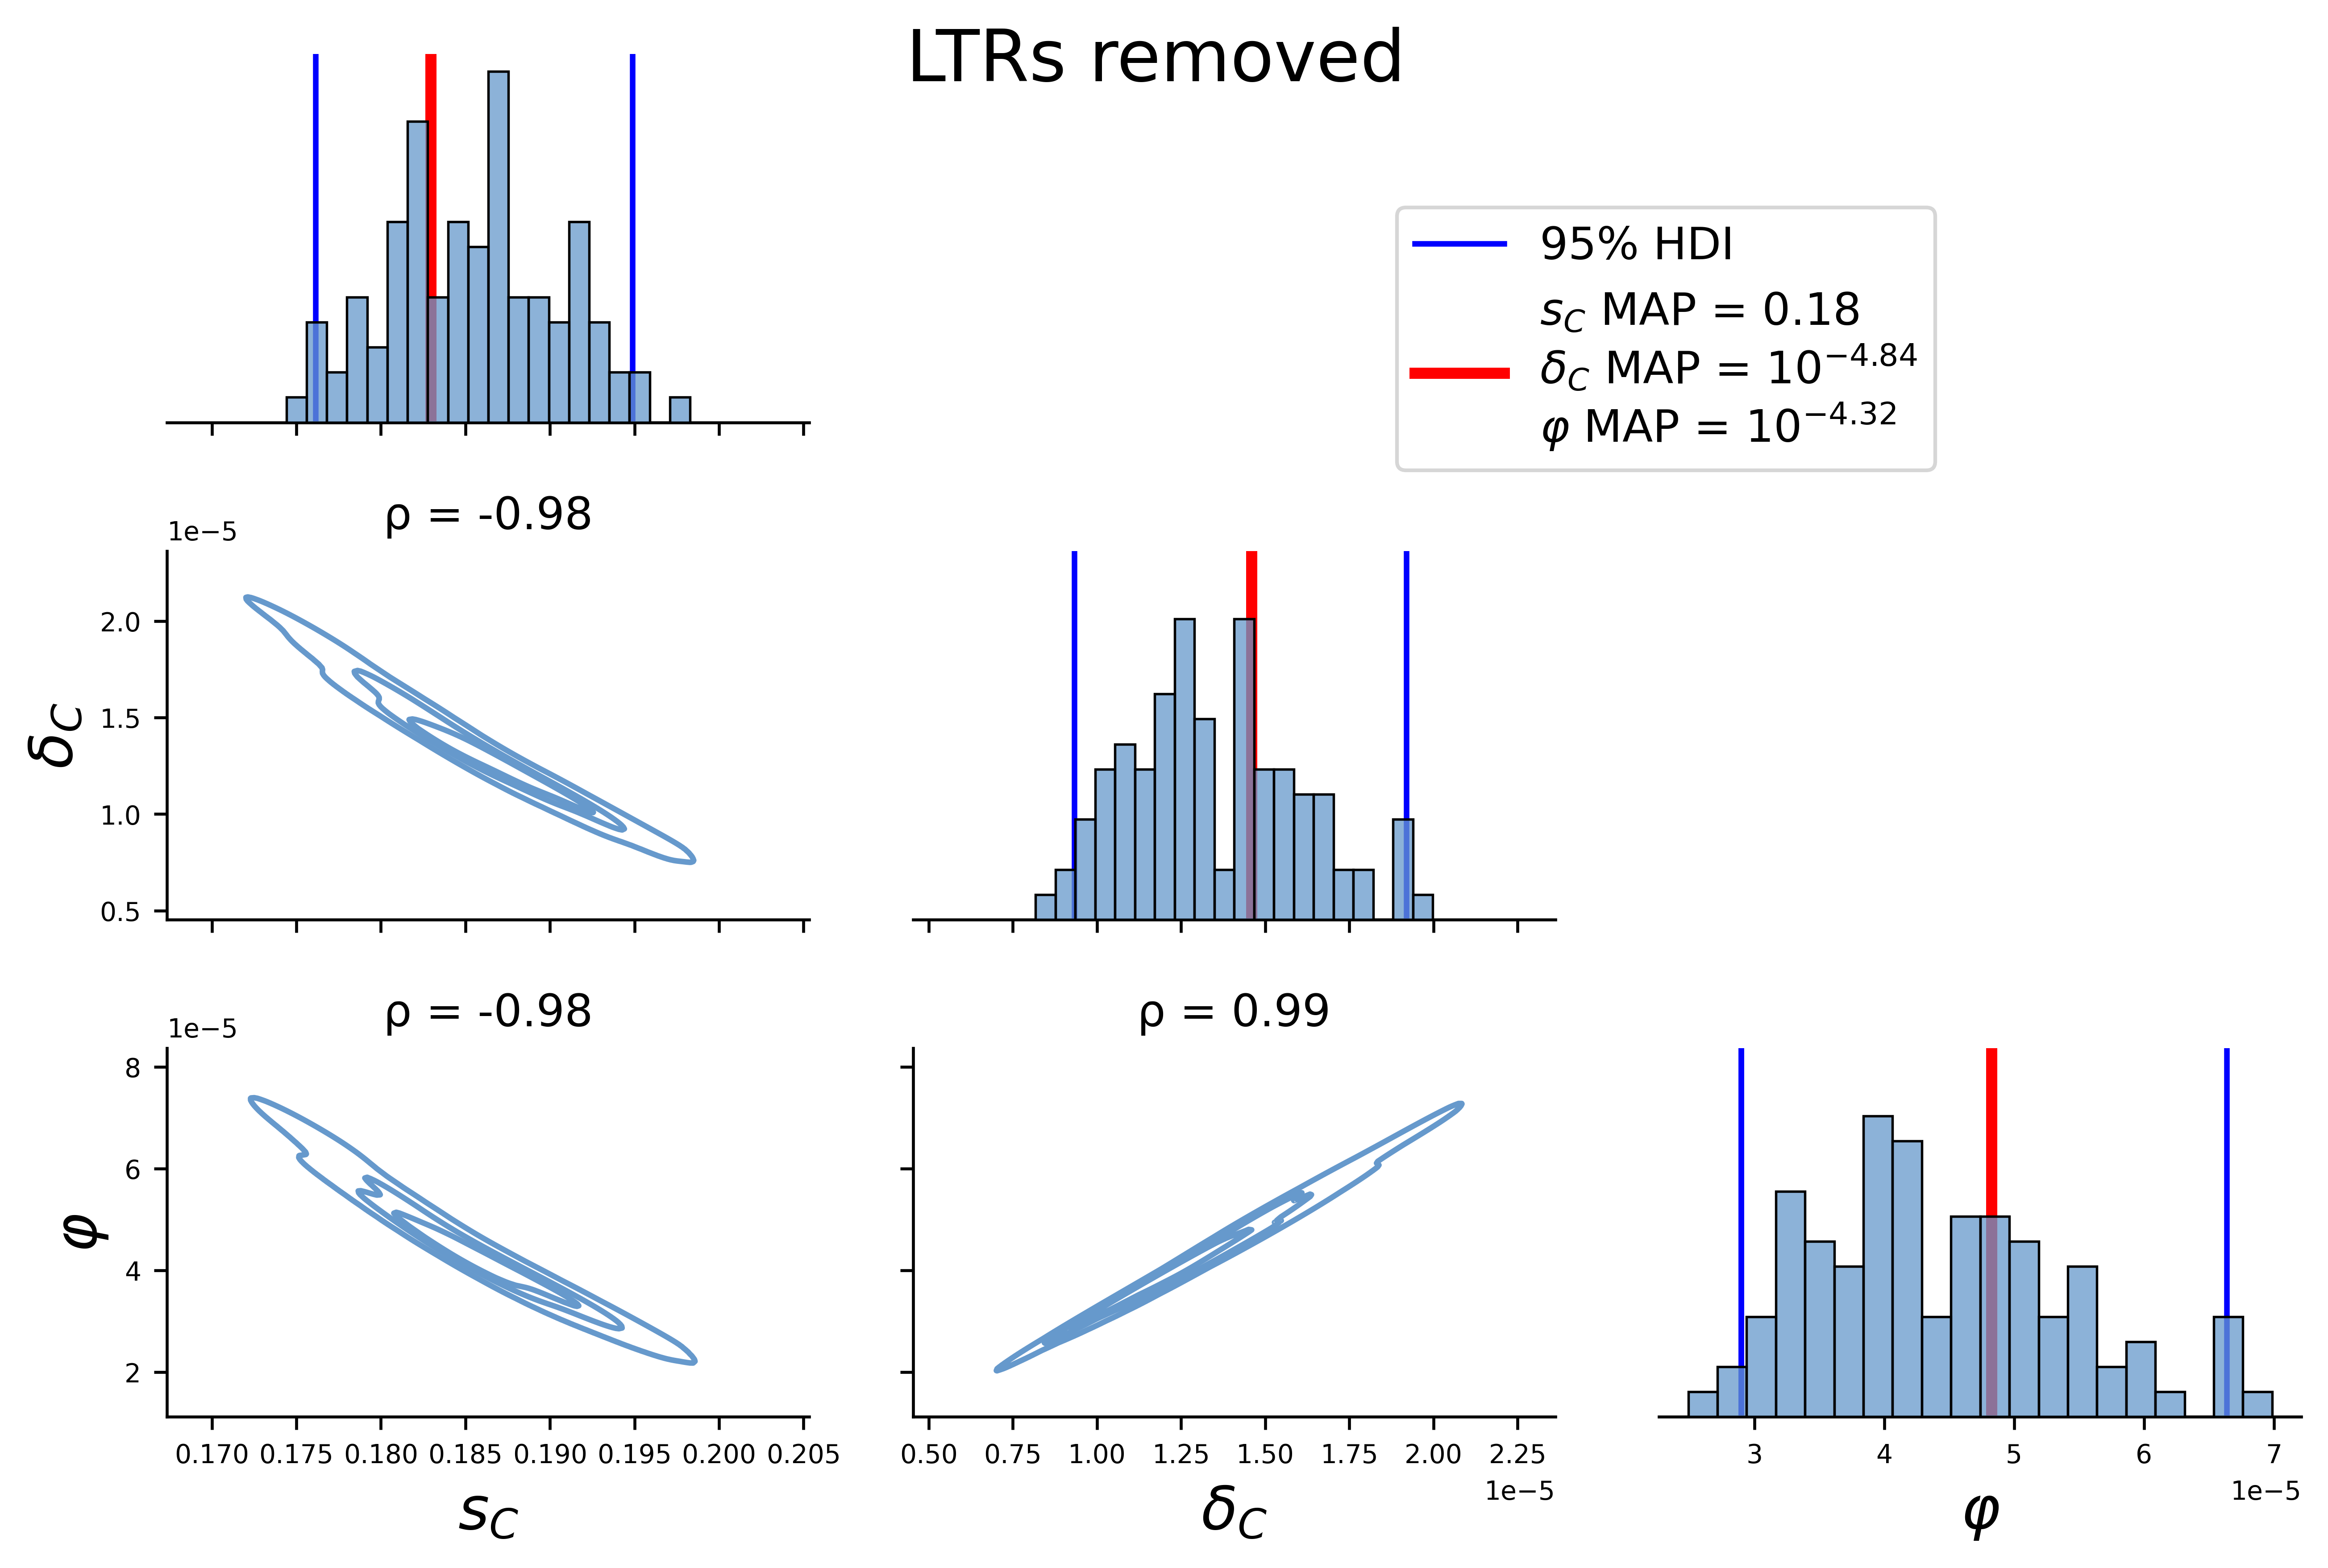

In [16]:
plotline('ltr')

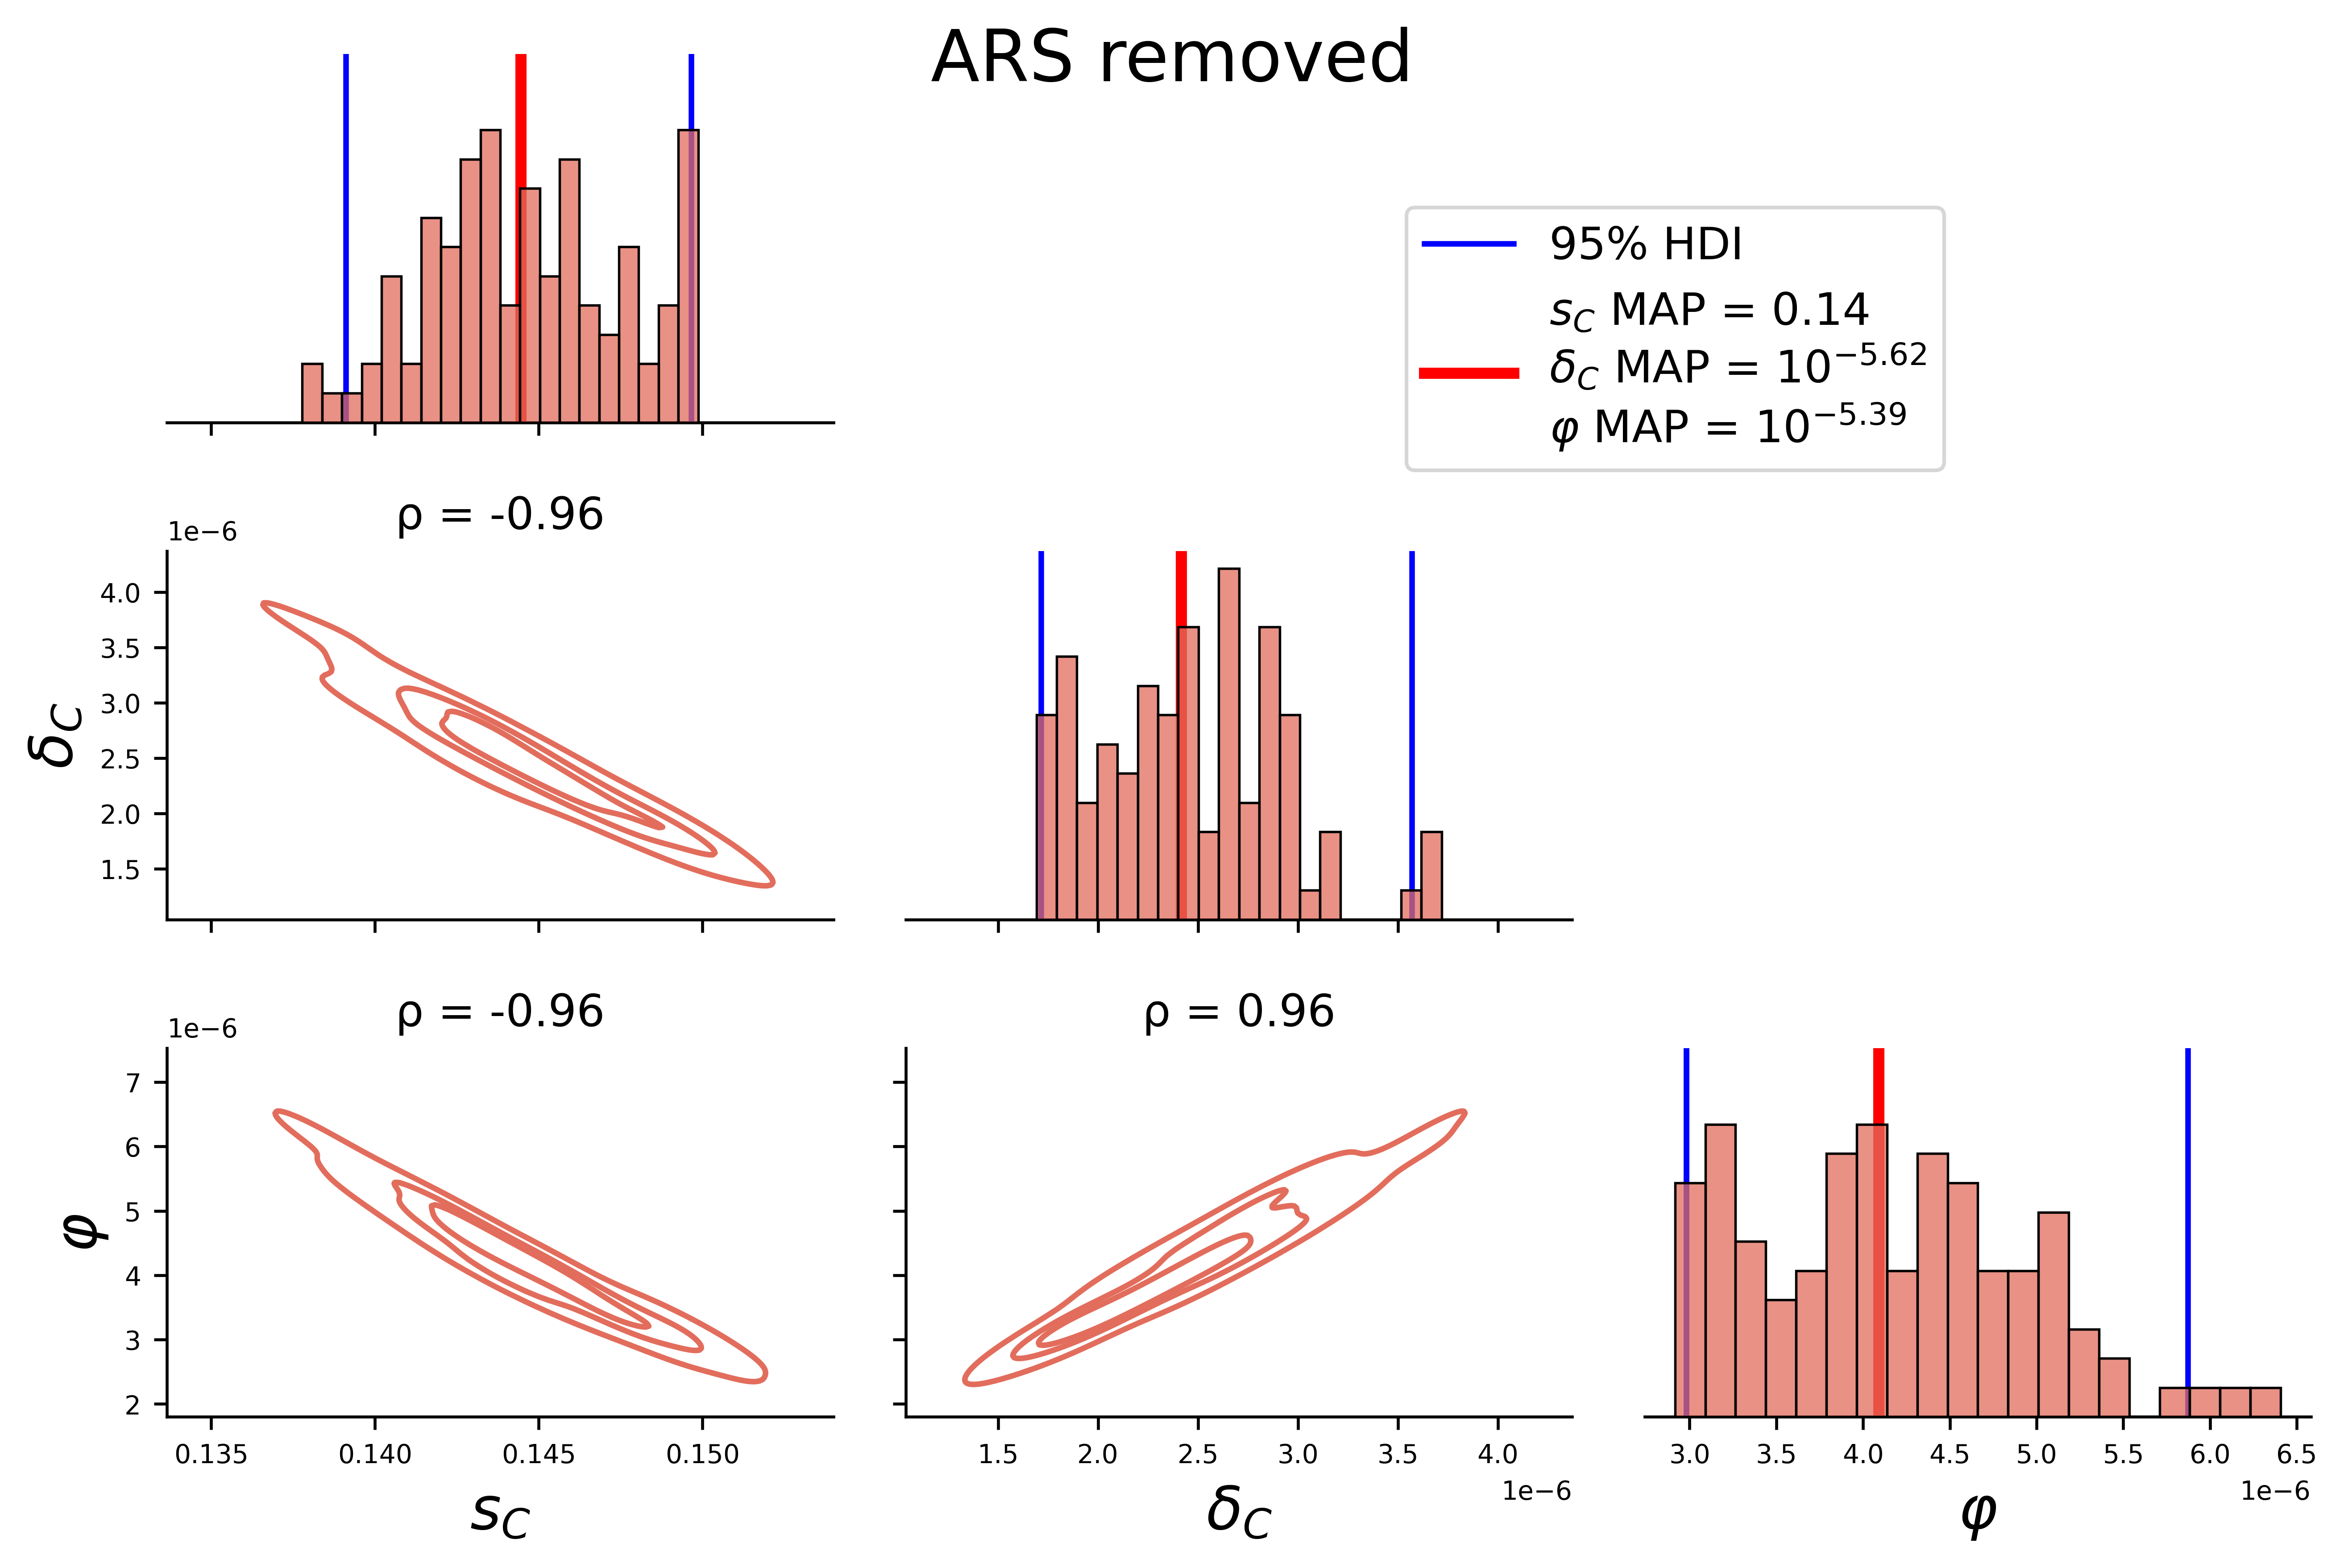

In [17]:
plotline('ars')

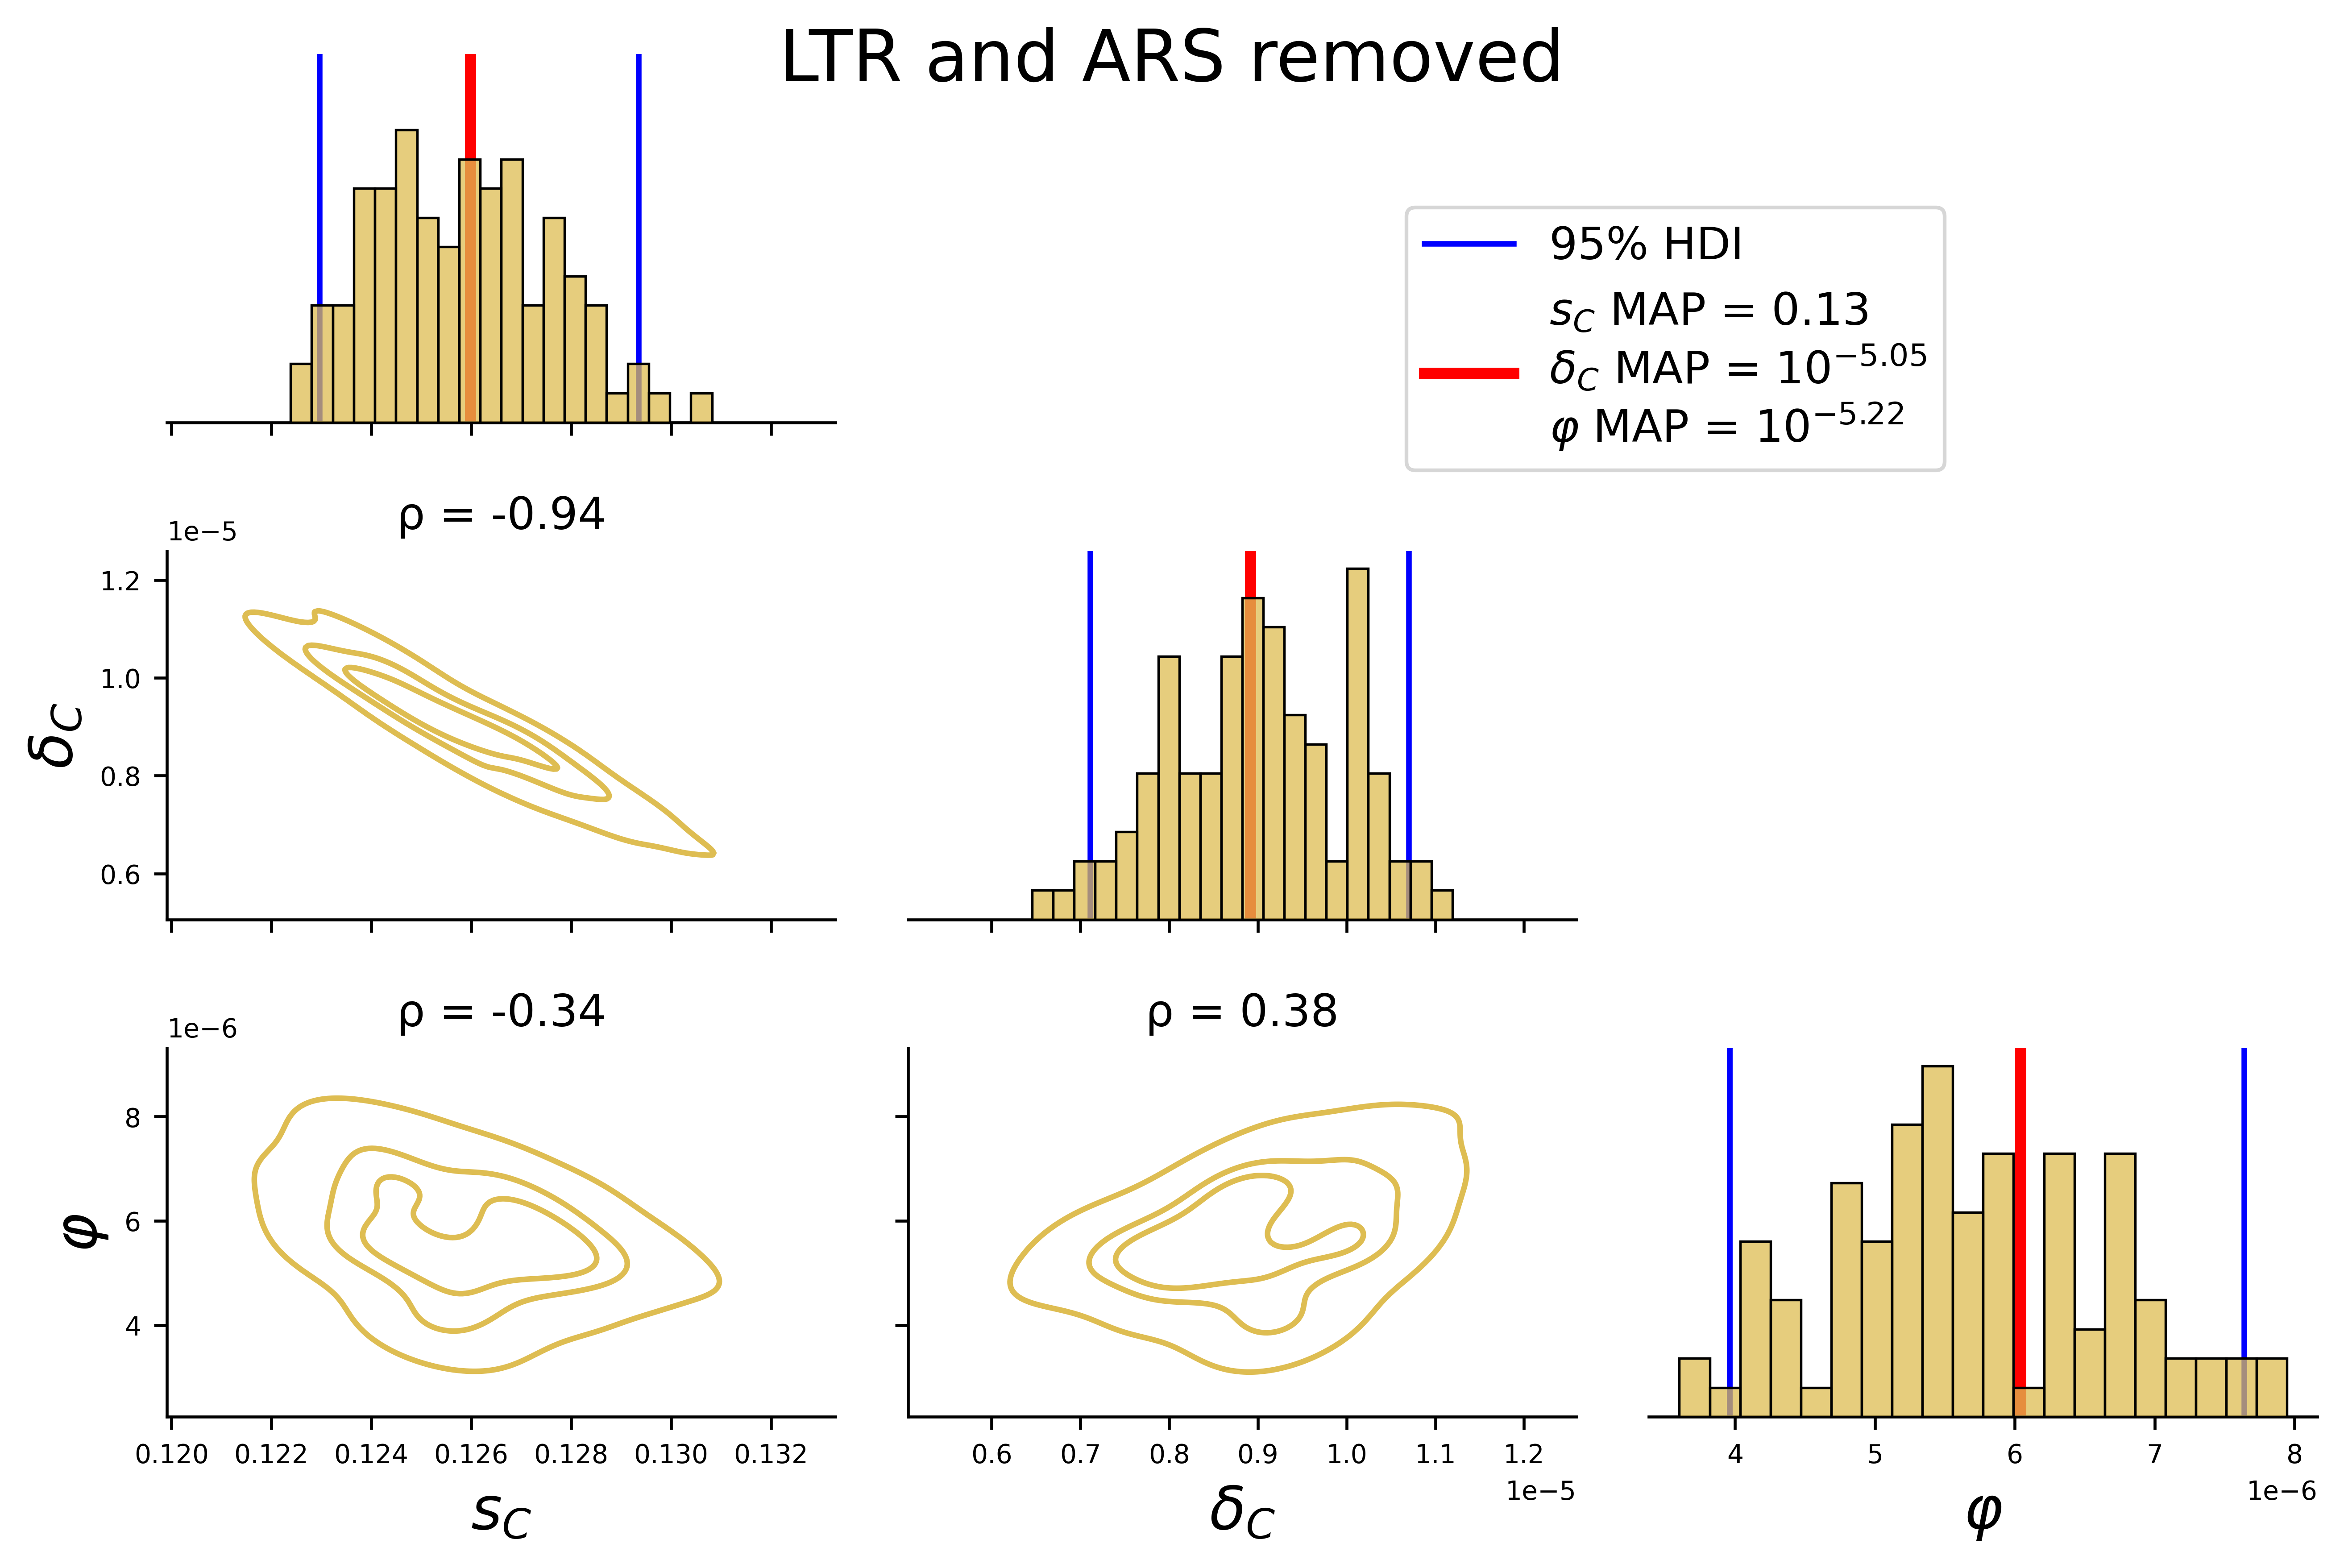

In [18]:
plotline('all')

# Collective Posterior Validation

## Predictive Checks - Simulate Collective Posterior MAP and compare to empirical observations

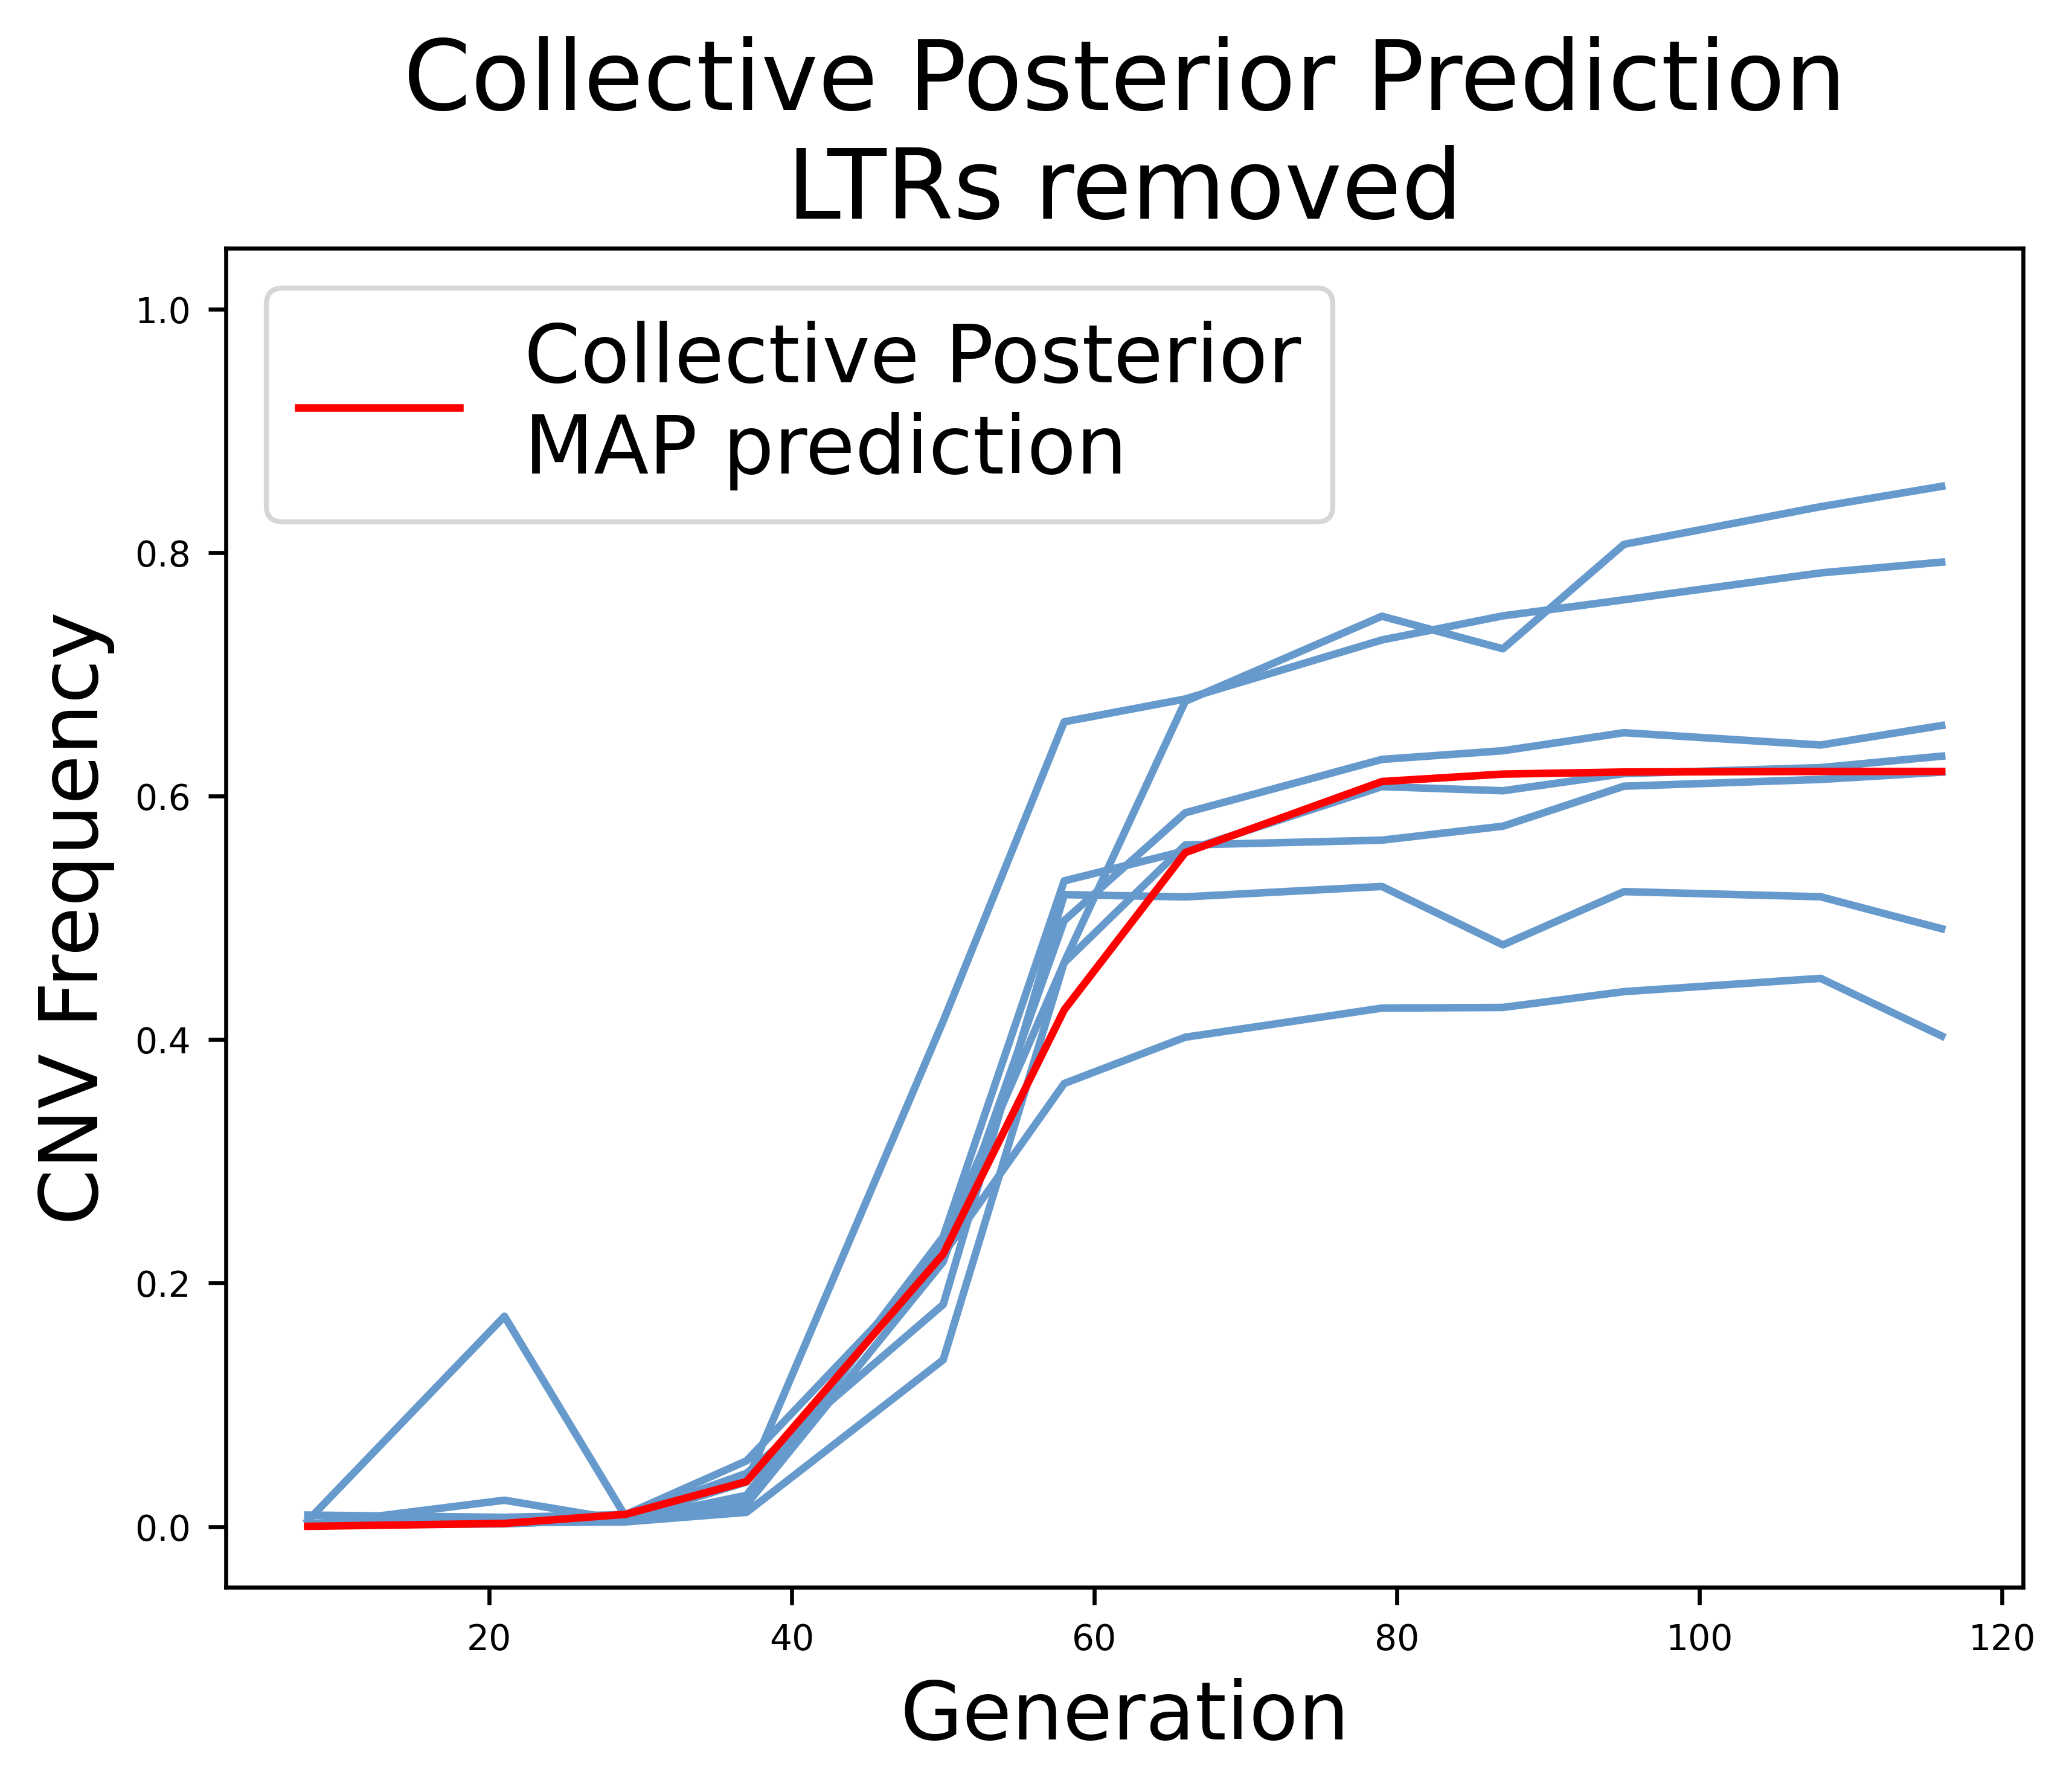

In [11]:
from cnv_simulation_initial_beneficial import CNVsimulator_simpleWF

# Model (simulator)
reps = 1
generation = pd.read_csv('Chuong_116_gens.txt', delimiter = ', ', engine='python')
generation = generation.columns.astype('int')
N = 3.3e8

def CNVsimulator(cnv_params):
    cnv_params = np.asarray(torch.squeeze(cnv_params,0))
    states = CNVsimulator_simpleWF(reps = reps, N=N, generation=generation, seed=73, parameters=cnv_params)
    return states

# Showing one example
line = 'ltr'
op = collective_posteriors[line]
for i in range(len(op.Xs)):
    plt.plot(generation.tolist(),op.Xs.iloc[i,:], color=rep_colors[line])

# Collective MAP
collective_map = op.map
params = torch.tensor(list(collective_map), dtype=torch.float64)
x = CNVsimulator(params).T
plt.plot(generation.tolist(),x, label = 'Collective Posterior\nMAP prediction', color='red')

# Plotting
plt.legend()
plt.title(f'Collective Posterior Prediction\n{label_dict[line]}')

plt.xlabel('Generation')
plt.ylabel('CNV Frequency')
plt.ylim(-0.05,1.05)
plt.show()

# Sensitivity to $\epsilon$

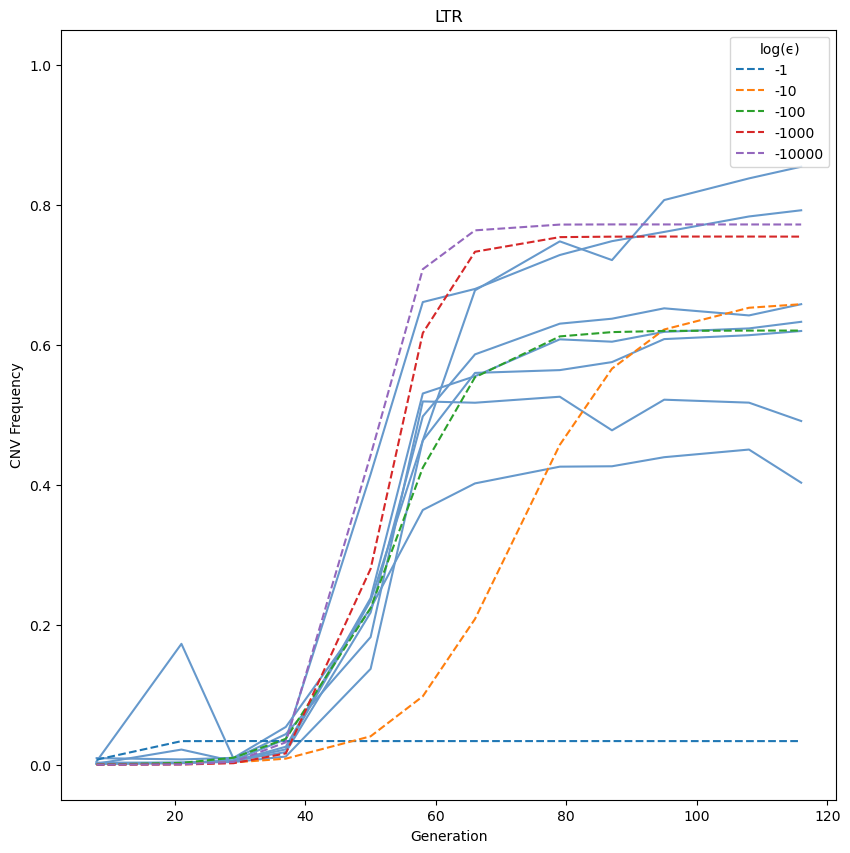

In [22]:
def plot_epsilons(ax, line, epsilons):
# Plot Collective Posterior prediction for WT
# Get data
    op = collective_posteriors[line]
    for i in range(len(op.Xs)):
        ax.plot(generation.tolist(),op.Xs.iloc[i,:], color=rep_colors[line])

    # Collective MAP
    for ϵ in epsilons:
        opp = CollectivePosterior(op.prior, op.amortized_posterior, Xs=op.Xs, n_eval=100, log_C=1, epsilon=ϵ)
        opp.get_log_C()
        collective_map = opp.get_map()
        params = torch.tensor(list(collective_map), dtype=torch.float64)
        x = CNVsimulator(params).T
        ax.plot(generation.tolist(),x, label = ϵ, linestyle='--')

    # Plotting
    ax.legend(title = 'log(ϵ)')
    ax.set_title(f'{line.upper()}')
    ax.set_xlabel('Generation')
    ax.set_ylabel('CNV Frequency')
    ax.set_ylim(-0.05,1.05)

fig, ax = plt.subplots(figsize=(10,10))
epsilons=[-1,-10,-100,-1000, -10000]
plot_epsilons(ax, 'ltr', epsilons)

## All lines (around $\epsilon=100$)

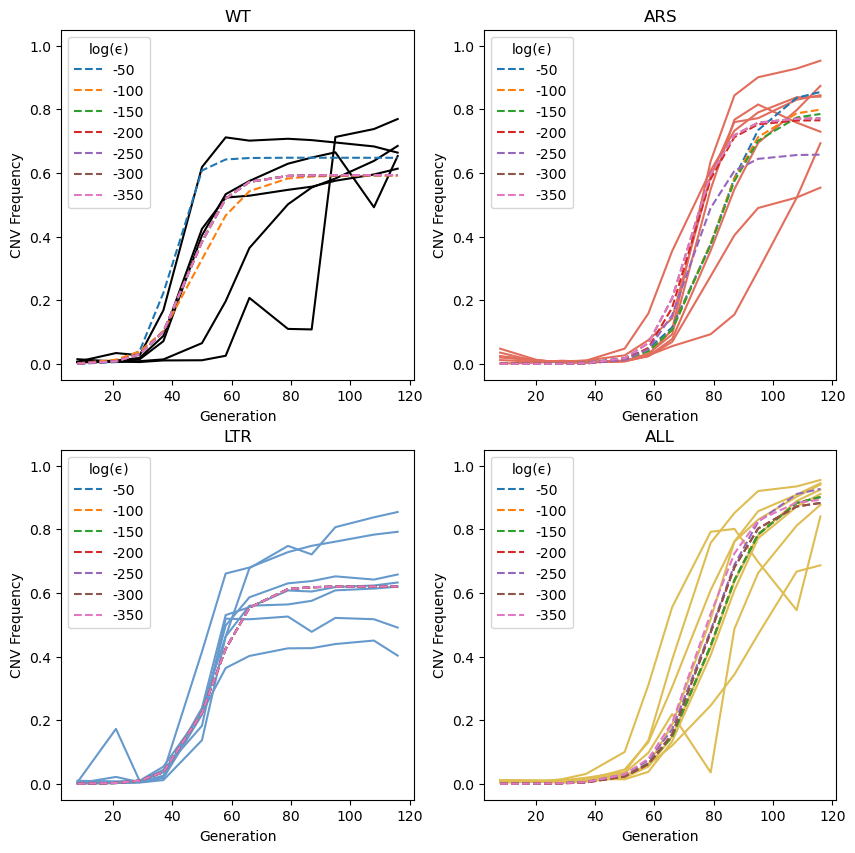

In [23]:
fig, ax = plt.subplots(2,2, figsize=(10,10))
epsilons = [-50,-100,-150,-200,-250,-300, -350]
plot_epsilons(ax[0,0], 'wt', epsilons)
plot_epsilons(ax[1,0], 'ltr', epsilons)
plot_epsilons(ax[0,1], 'ars', epsilons)
plot_epsilons(ax[1,1], 'all', epsilons)
plt.show()

# MAPs and samples

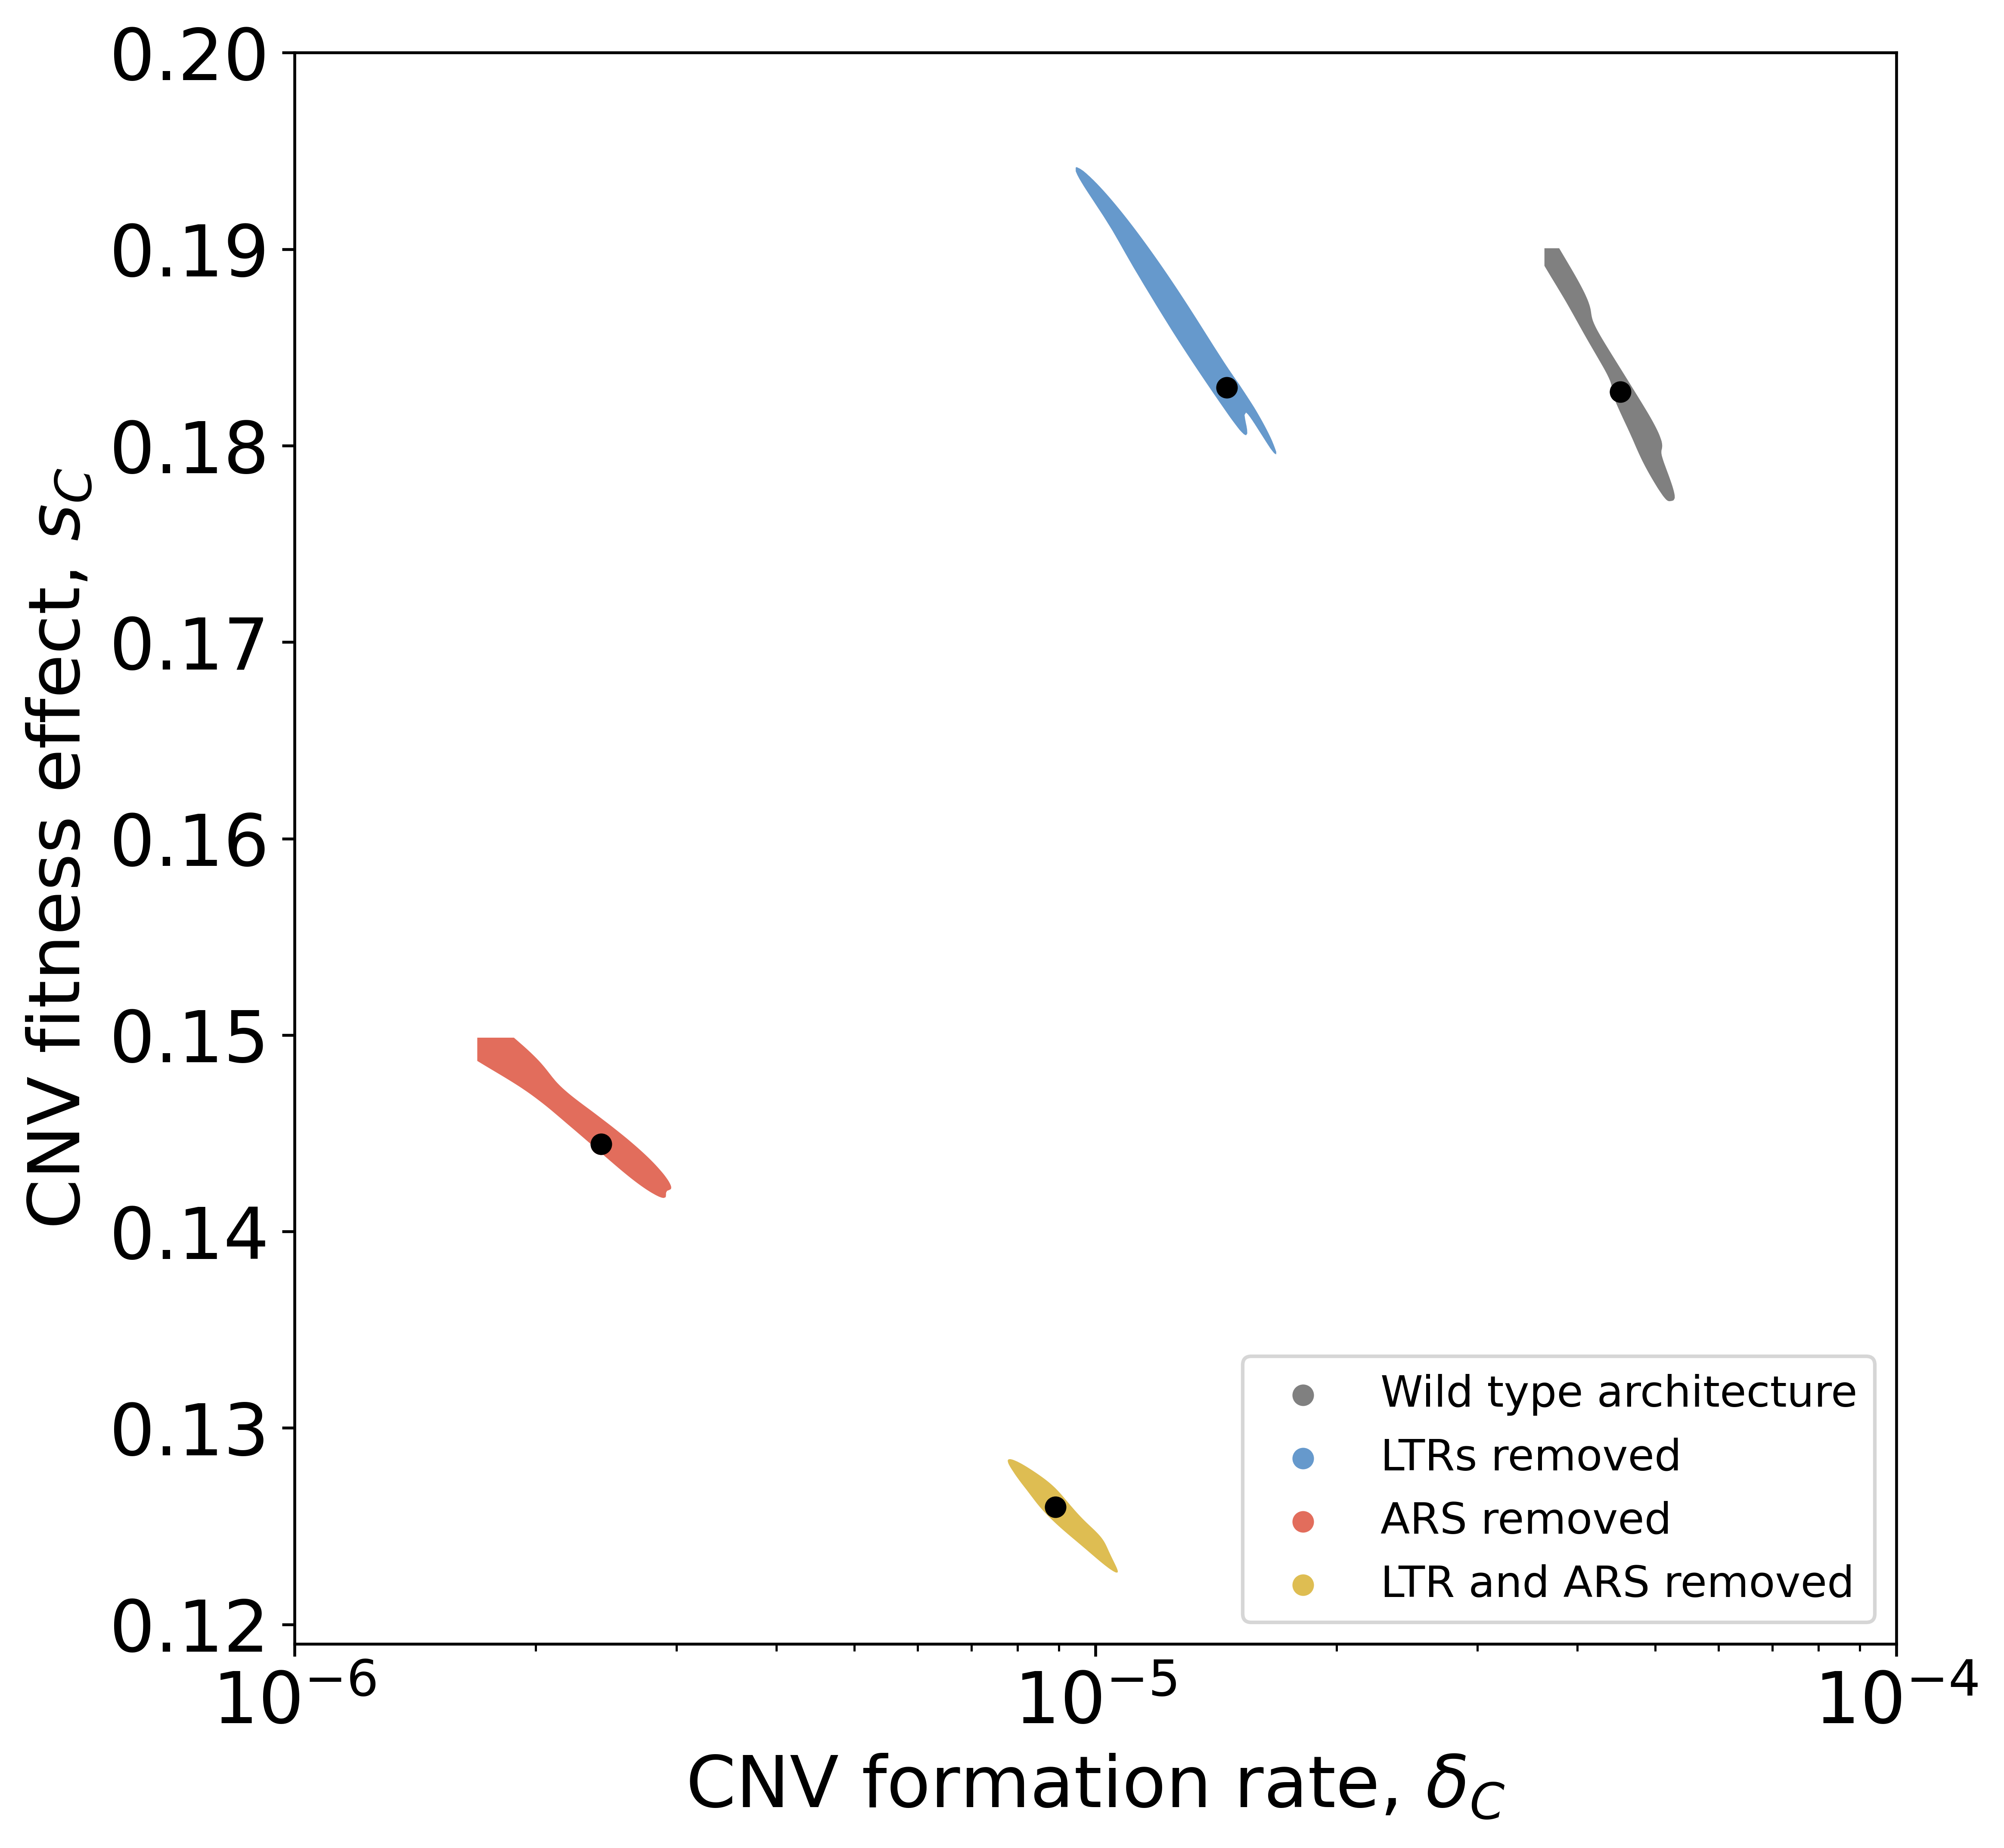

In [4]:
from seaborn import scatterplot, kdeplot
import arviz as az
import matplotlib as mpl

# fonts
label_size = 20
mpl.rcParams['xtick.labelsize'] = label_size 
mpl.rcParams['ytick.labelsize'] = label_size 
mpl.rcParams['font.size'] = label_size
mpl.rcParams["lines.linewidth"] = 0.001

# Plot formation rate δc and fitness effect Sc for given MAPs
def plot_maps(ax, lines, title):
    colors =  {'wt':"Greys", 'ltr':"Blues", 'ars': "Reds", 'all':"YlOrRd_r"}
    rep_colors = {'wt':"grey", 'ltr':"#6699cc", 'ars': "#e26d5c", 'all':"#DEBD52", "lauer": "grey"}
    for line in lines: 
        op = collective_posteriors[line]
        mapp = op.map
        x, y = 10**mapp[1], 10**mapp[0]
        
        
        # Add samples
        samples = op.samples
        xdf, ydf = 10**samples[:,1], 10**samples[:,0]
        
        # 50% HDR
        a = az.plot_kde(
            xdf,
            ydf,
            hdi_probs=[0.5],
            ax=ax, contourf_kwargs={'colors':[rep_colors[line]]},
                         label=label_dict[line])
        
        ax.scatter(x, y, color=rep_colors[line], s = 25, label = label_dict[line]) # Right color for legend
        ax.scatter(x, y, color='k', s = 25) # plot MAP in white
        ax.set_xlabel('CNV formation rate, $δ_C$')
        ax.set_ylabel('CNV fitness effect, $s_C$')
        ax.set_title(title)
        ax.set_xscale('log')
        ax.legend(loc='lower right', fontsize=12)

    
fig, ax = plt.subplots(figsize=(8,8))
ax.set_ylim(0.119,0.2)
ax.set_xlim(10**-6, 10**-4)
        
lines = ['wt', 'ltr', 'ars', 'all']
plot_maps(ax, lines, '')
plt.show()